# 1. Build your own convolutional neural network using pytorch

In [1]:
# Import the libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Set random seed 
torch.manual_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda:0


In [3]:
# Define the paths
train_path = "/kaggle/input/dog-heart-data-project1/Dog_X_ray/Dog_heart/Dog_heart/Train"
valid_path = "/kaggle/input/dog-heart-data-project1/Dog_X_ray/Dog_heart/Dog_heart/Valid"
test_path = "/kaggle/input/dog-heart-data-project1/Dog_X_ray/Test/Test"

# Define the class mapping
class_names = {"Large": 0, "Normal": 1, "Small": 2}

In [4]:
# Define transformations
# Data augmentation for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# For validation and testing
valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
# Custom Dataset for training and validation data
class DogHeartDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.images = []
        self.labels = []
        
        # Iterate through each class folder
        for class_name in class_names.keys():
            class_path = os.path.join(data_path, class_name)
            if os.path.isdir(class_path):
                class_label = class_names[class_name]
                # Add all images in this class folder
                for img_name in os.listdir(class_path):
                    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                        self.images.append(os.path.join(class_path, img_name))
                        self.labels.append(class_label)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]
        
        # Open image and apply transformations
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
            
        return image, label

# Custom Dataset for test data
class TestDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.images = []
        self.image_names = []
        
        # Add all images in the test folder
        for img_name in os.listdir(data_path):
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                self.images.append(os.path.join(data_path, img_name))
                self.image_names.append(img_name)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        img_name = self.image_names[idx]
        
        # Open image and apply transformations
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
            
        return image, img_name

In [6]:
# Create datasets
train_dataset = DogHeartDataset(train_path, transform=train_transform)
valid_dataset = DogHeartDataset(valid_path, transform=valid_transform)
test_dataset = TestDataset(test_path, transform=valid_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

# Print dataset information
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(valid_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 1400
Validation samples: 200
Test samples: 400


In [7]:
# Define the CNN model
class DogHeartCNN(nn.Module):
    def __init__(self):
        super(DogHeartCNN, self).__init__()

        self.conv_block1 = self._conv_block(3, 32)
        self.conv_block2 = self._conv_block(32, 64)
        self.conv_block3 = self._conv_block(64, 128)
        self.conv_block4 = self._conv_block(128, 256)
        self.conv_block5 = self._conv_block(256, 512)

        self.pool = nn.MaxPool2d(2, 2)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 3)
        
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def _conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.pool(x)
        
        x = self.conv_block2(x)
        x = self.pool(x)
        
        x = self.conv_block3(x)
        x = self.pool(x)
        
        x = self.conv_block4(x)
        x = self.pool(x)
        
        x = self.conv_block5(x)
        x = self.pool(x)
        
        x = self.global_pool(x)
        x = x.view(-1, 512)
        
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)
        
        return x

# 2. Train your model using dog heart dataset (you may need to use  Google Colab (or Kaggle) with GPU to train your code) 

### (1) use torchvision.datasets.ImageFolder for the training dataset
### (2) use custom dataloader for test dataset (return image tensor and file name)

In [8]:
# Create model
model = DogHeartCNN().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [9]:
# Training function
def train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs=100):
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    best_valid_acc = 0.0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_train_loss = running_loss / len(train_dataset)
        epoch_train_acc = correct / total
        train_losses.append(epoch_train_loss)
        train_accuracies.append(epoch_train_acc)
        
        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        epoch_valid_loss = running_loss / len(valid_dataset)
        epoch_valid_acc = correct / total
        valid_losses.append(epoch_valid_loss)
        valid_accuracies.append(epoch_valid_acc)
        
        # Step the scheduler based on validation loss
        scheduler.step(epoch_valid_loss)
        
        # Print epoch statistics
        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.4f} | "
              f"Valid Loss: {epoch_valid_loss:.4f} | Valid Acc: {epoch_valid_acc:.4f}")
        
        # Save the best model
        if epoch_valid_acc > best_valid_acc:
            best_valid_acc = epoch_valid_acc
            torch.save(model.state_dict(), 'best_dog_heart_model.pth')
            print(f"Model saved with validation accuracy: {best_valid_acc:.4f}")
    
    return train_losses, valid_losses, train_accuracies, valid_accuracies

# Train the model
train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(
    model, train_loader, valid_loader, criterion, optimizer, scheduler)

Epoch 1/100 | Train Loss: 1.0308 | Train Acc: 0.4229 | Valid Loss: 0.9823 | Valid Acc: 0.3800
Model saved with validation accuracy: 0.3800
Epoch 2/100 | Train Loss: 0.9535 | Train Acc: 0.4386 | Valid Loss: 0.9034 | Valid Acc: 0.4050
Model saved with validation accuracy: 0.4050
Epoch 3/100 | Train Loss: 0.9020 | Train Acc: 0.5107 | Valid Loss: 0.8589 | Valid Acc: 0.5500
Model saved with validation accuracy: 0.5500
Epoch 4/100 | Train Loss: 0.8168 | Train Acc: 0.5571 | Valid Loss: 0.8299 | Valid Acc: 0.5050
Epoch 5/100 | Train Loss: 0.7889 | Train Acc: 0.5800 | Valid Loss: 0.8316 | Valid Acc: 0.6250
Model saved with validation accuracy: 0.6250
Epoch 6/100 | Train Loss: 0.7529 | Train Acc: 0.6043 | Valid Loss: 0.7374 | Valid Acc: 0.6450
Model saved with validation accuracy: 0.6450
Epoch 7/100 | Train Loss: 0.7450 | Train Acc: 0.6114 | Valid Loss: 0.7297 | Valid Acc: 0.6050
Epoch 8/100 | Train Loss: 0.7232 | Train Acc: 0.6500 | Valid Loss: 0.6735 | Valid Acc: 0.6550
Model saved with valida

In [10]:
# Print model architecture and parameters
print("Model Architecture:\n", model)

# Print each parameter name and its shape
print("\nModel Parameters:")
total_params = 0
for name, param in model.named_parameters():
    if param.requires_grad:  
        print(f"{name}: {param.shape}")
        total_params += param.numel()  

# Print the total number of trainable parameters
print(f"\nTotal Trainable Parameters: {total_params}")


Model Architecture:
 DogHeartCNN(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (conv_block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_runnin

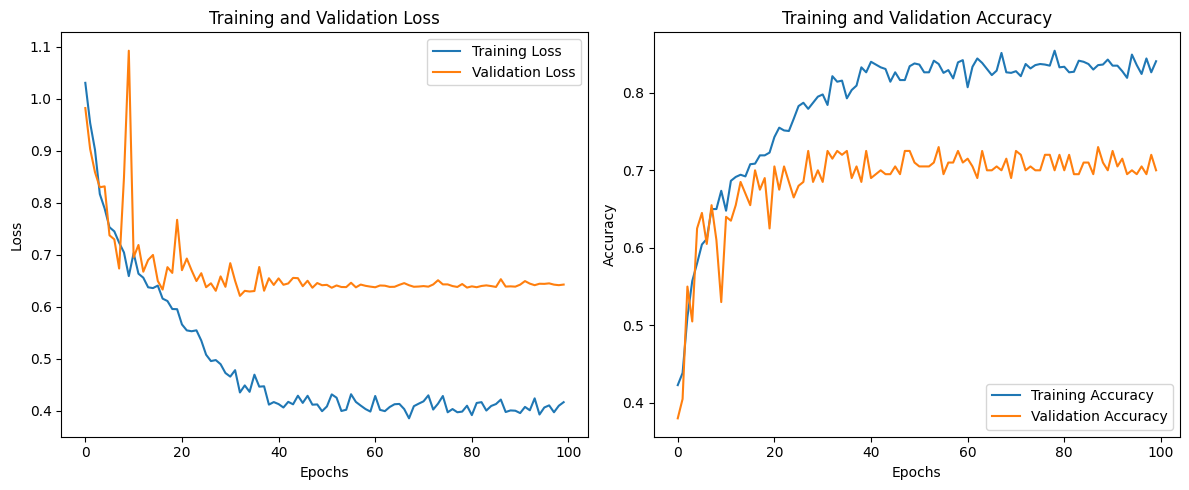

In [11]:
# Plot training and validation loss/accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.tight_layout()
plt.savefig('training_results.png')
plt.show()

In [12]:
# Load the best model for testing
model.load_state_dict(torch.load('best_dog_heart_model.pth'))
model.eval()

<ipython-input-12-6a6d1adbc303>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_dog_heart_model.pth'))


DogHeartCNN(
  (conv_block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (conv_block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2)

In [13]:
# Test the model and track predictions
predictions = []
image_names = []
correct = 0
total = 0

# For the validation set 
print("\nEvaluating on validation set:")
with torch.no_grad():
    for inputs, labels in valid_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

valid_accuracy = correct / total
print(f"Validation accuracy: {valid_accuracy:.4f}")

# Make predictions on test set
print("\nMaking predictions on test set:")
test_predictions = []

with torch.no_grad():
    for inputs, img_names in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        # Convert predictions to class names
        pred_class_idx = predicted.item()
        pred_class_name = list(class_names.keys())[list(class_names.values()).index(pred_class_idx)]
        
        # Store results
        test_predictions.append({
            'Image': img_names[0],
            'Predicted_Class': pred_class_name,
            'Predicted_Label': pred_class_idx
        })

# Create DataFrame and save predictions
test_df = pd.DataFrame(test_predictions)
test_df.to_csv('test11_predictions.csv', index=False)
print(f"Test predictions saved to 'test_predictions.csv'")
print(f"Validation accuracy: {valid_accuracy:.4f}")


Evaluating on validation set:
Validation accuracy: 0.7300

Making predictions on test set:
Test predictions saved to 'test_predictions.csv'
Validation accuracy: 0.7300


# 3. Evaluate your model using the developed software

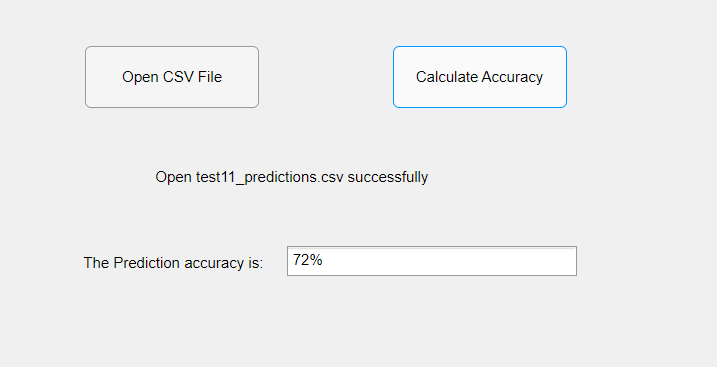

# 4. Compare results with [RVT paper](https://www.nature.com/articles/s41598-023-50063-x). Requirement: performance is better than VGG16: 75%

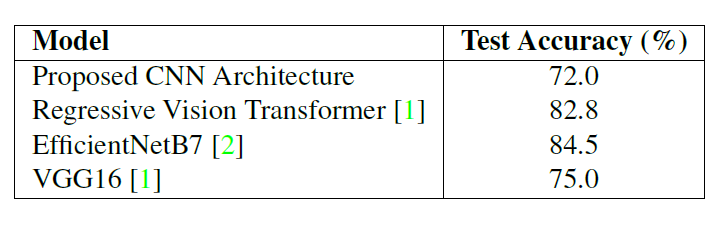

# 5. Write a four-page paper report using the shared LaTex template. Upload your paper to ResearchGate or Arxiv, and put your paper link and GitHub weight link here.

Research paper: https://www.researchgate.net/publication/390174202_Detection_of_Canine_Cardiomegaly_Using_Deep_Convolutional_Neural_Networks

GitHub link: https://github.com/Venkatalakshmikottapalli/X-ray-Image-Classification/tree/main/files


# 6. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points


(4). Method  ---- 20 points

(5). Results ---- 20 points

     > = 75 % -->10 points
     < 55 % -->0 points
     >= 55 % & < 75% --> 0.5 point/percent
     

(6). Discussion - 10 points